# Active Learning on the Support Vector Machine classifier

Now that the data is preprocessed we can start with our actual experiments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skactiveml

#Different classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.base import BaseEstimator
from sklearn import pipeline, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split, StratifiedKFold
from skactiveml.pool import UncertaintySampling, QueryByCommittee, GreedySamplingX
from skactiveml.classifier import SklearnClassifier
from skactiveml.base import ClassFrequencyEstimator, SkactivemlClassifier
from skactiveml.visualization import plot_decision_boundary, plot_utilities
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.pool import RandomSampling, UncertaintySampling, ProbabilisticAL, CostEmbeddingAL, EpistemicUncertaintySampling

First we need to read in the dataframe where we categorize the target in numbers and get the input features and labels

In [3]:
#read in dataframe
data = pd.read_csv('dataset_1.csv')

#define the target and categorize it in numbers
target = 'PROFILE'
profile_options = np.unique(data['PROFILE'])
for index, profile in enumerate(profile_options):
    data.loc[data['PROFILE'] == profile,'PROFILE'] = index

#then get your input features and labels
X = np.array(data.drop(target, axis=1).values.tolist())
y_true = np.array(data[target]).astype('int')

### 1-2) Applying cross-validation on the classifier without tuning the hyperparameters

In [4]:
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

def balanced_accuracy(y_pred, y_test):
    acc0, acc1 = class_accs(y_pred, y_test)
    return (acc0 + acc1) / 2

def cross_validation(X, y, folds, clf):
    skf = StratifiedKFold(n_splits=folds)
    bal_accs = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bal_acc = balanced_accuracy(y_pred, y_test)
        bal_accs.append(bal_acc)
    print(f"Avg balanced accuracy: {np.mean(bal_accs):.3f}")
    print()

In [6]:
print('SVM')
clf = pipeline.Pipeline([('sc', StandardScaler()), 
                         ('svm', SVC())])
cross_validation(X, y_true, 5, clf)

SVM
Avg balanced accuracy: 0.919



### 3) Tuning the Hyperparameters
TO DO: normaal de nested_cv gebruiken maar kan nog geen best parameters printen

In [7]:
def grid_search(X, y, model, p_grid):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    clf = GridSearchCV(estimator=model, param_grid=p_grid, scoring="balanced_accuracy", cv=cv)
    clf.fit(X, y)
    print(f"Best score: {clf.best_score_:.4f}")
    print(f"Best params: {clf.best_params_}")
    return clf.best_params_
    
def nested_cv(X, y, model, p_grid):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X, y, cv=outer_cv)
    return nested_score.mean()

In [12]:
print("Suport Vector Machine")
clf = make_pipeline(StandardScaler(), SVC(random_state=0))
#print(SVC.get_params().keys())
best_param_dt = grid_search(X, y_true, clf, {"svc__kernel": ['linear', 'rbf', 'poly'], "svc__C": [1, 10, 100]})

Suport Vector Machine
Best score: 0.9300
Best params: {'svc__C': 10, 'svc__kernel': 'rbf'}


### 4) Splitsing in Training and Testing set

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y_true,test_size = 0.25)

In [14]:
print('Length of the training set: '+str(len(X_train)))

Length of the training set: 2250


### 5) Apply Active Learning
Daarvoor normaliseren we eerst de data

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [21]:
def ActiveLearning_UncertaintySampling(X, y_true, n_cycles, batch_size, clf, method='entropy'):
    """
    In uncertainty sampling, the unlabeled instance that the model is the least certain about is chosen.
    
    :param X: Features of the dataset.
    :param y_true: True classes of the dataset.
    :param n_cycles: Number of times that a query has to be taken.
    :param batch_size: Size of the batch of a single query.
    :param clf: Classifier method.
    :param method: Optimal parameter determining the measure for uncertainty. Default is entropy.
    """
        
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    initials = np.random.randint(0, len(X), batch_size)
    y[initials] = y_true[initials]
    clf.fit(X, y)
    
    qs = UncertaintySampling(method=method)
    
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, clf=clf, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
        
    return cycle, accuracies


def ActiveLearning_RandomSampling(X, y_true, n_cycles, batch_size, clf):
    """
    In random sampling, the query is chosen randomly from the unlabeled instances.
    
    :param X: Features of the dataset.
    :param y_true: True classes of the dataset.
    :param n_cycles: Number of times that a query has to be taken.
    :param batch_size: Size of the batch of a single query.
    :param clf: Classifier method.
    """
        
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    initials = np.random.randint(0, len(X), batch_size)
    y[initials] = y_true[initials]
    clf.fit(X, y)
    
    qs = RandomSampling()
    
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies


def ActiveLearning_QueryByCommittee(X, y_true, n_cycles, batch_size, clf, committee_size=3):
    """
    The query-by-committee algorithm involves maintaining a committee of models which are all trained on the 
    current labeled set L, but representing competing hypotheses. Each committee member is allowed to vote on 
    the labeling of the query candidates. The most informative query is considered to be the instance about 
    which they most disagree.
    
    :param X: Features of the dataset.
    :param y_true: True classes of the dataset.
    :param n_cycles: Number of times that a query has to be taken.
    :param batch_size: Size of the batch of a single query.
    :param clf: Classifier method.
    :param committee_size: Optional parameter giving number of methods in the committee. Default value is three.
    """
    
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    initials = np.random.randint(0, len(X), batch_size)
    y[initials] = y_true[initials]
    ensemble_bagging = SklearnClassifier(estimator=BaggingClassifier(base_estimator=clf, n_estimators=committee_size), 
                                         classes=np.unique(y_true))
    ensemble_bagging.fit(X, y)
    
    qs = QueryByCommittee()
            
    accuracies = []
    cycle = []
    
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, ensemble=ensemble_bagging, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        ensemble_bagging.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(ensemble_bagging.score(X,y_true))
        cycle.append(c*batch_size)
        
    return cycle, accuracies


def ActiveLearning_CostEmbeddingAL(X, y_true, n_cycles, batch_size, clf, classes):
    """
    The Cost Embedding algorithm is a cost sensitive multi-class algorithm. It assumes that each class has at 
    least one sample in the labeled pool. Cost-sensitive active learning algorithms allows the user to pass in the 
    cost matrix as a parameter and select the data points that it thinks to perform the best on the given cost matrix.
    Assume we have a total of K classes, cost matrix can be represented as a K*K matrix. The i-th row, j-th column 
    represents the cost of the ground truth being i-th class and prediction as j-th class. The goal is to minimize 
    the total cost.
    
    :param X: Features of the dataset.
    :param y_true: True classes of the dataset.
    :param n_cycles: Number of times that a query has to be taken.
    :param batch_size: Size of the batch of a single query.
    :param clf: Classifier method.
    :param classes: array-like of shape(n_classes,)
    """
    
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    initials = np.random.randint(0, len(X), batch_size)
    y[initials] = y_true[initials]
    clf.fit(X, y)
    
    qs = CostEmbeddingAL(classes=classes)
    
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies


def ActiveLearning_GreedySamplingX(X, y_true, n_cycles, batch_size, clf):
    """
    In greedy sampling, the query strategy tries to select those samples that increase the diversity of 
    the feature space the most.
    
    :param X: Features of the dataset.
    :param y_true: True classes of the dataset.
    :param n_cycles: Number of times that a query has to be taken.
    :param batch_size: Size of the batch of a single query.
    :param clf: Classifier method.
    """
        
    y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
    initials = np.random.randint(0, len(X), batch_size)
    y[initials] = y_true[initials]
    clf.fit(X, y)
    
    qs = GreedySamplingX()
    
    accuracies = []
    cycle = []
    for c in range(n_cycles):
        query_idx = qs.query(X=X, y=y, batch_size=batch_size)
        y[query_idx] = y_true[query_idx]
        clf.fit(X, y)
        
        unlbld_idx = unlabeled_indices(y)
        lbld_idx = labeled_indices(y)
        accuracies.append(clf.score(X,y_true))
        cycle.append(c*batch_size)
    return cycle, accuracies

def plot_AL(cycle, accuracies, qs_name, clf_name):
    plt.plot(cycle, accuracies, label = qs_name)
    plt.xlabel('Labeled samples')
    plt.ylabel('Accuracy')
    plt.title(clf_name)
    plt.legend()
    plt.show()

Support Vector Machine


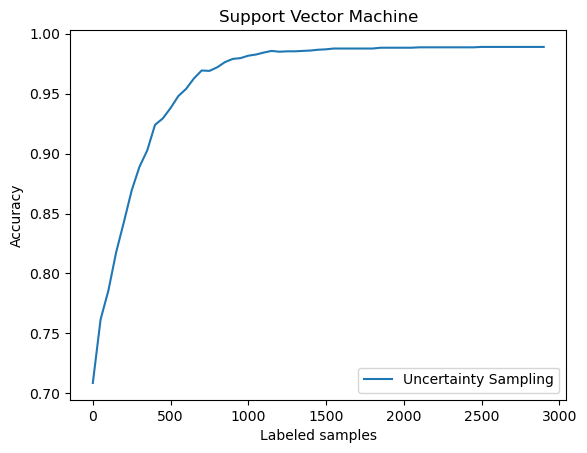

In [22]:
print('Support Vector Machine')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
clf_name = 'Support Vector Machine'
qs = UncertaintySampling(method='entropy')
qs_name = 'Uncertainty Sampling'
cycle, accuracies = ActiveLearning_UncertaintySampling(X_scaled, y_true, 59, 50, clf)
plot_AL(cycle, accuracies, qs_name, clf_name)

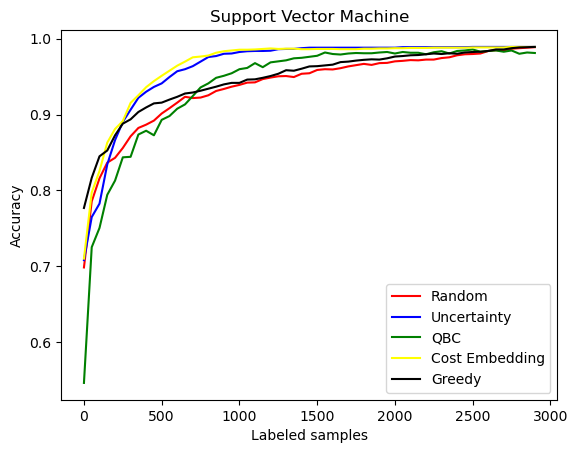

In [23]:
clf_name = 'Support Vector Machine'
colors = ['blue', 'red', 'green']

clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_RandomSampling(X_scaled, y_true, 59, 50, clf)
plt.plot(cycle, accuracies, color = 'red', label = 'Random')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_UncertaintySampling(X_scaled, y_true, 59, 50, clf)
plt.plot(cycle, accuracies, color = 'blue', label = 'Uncertainty')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_QueryByCommittee(X_scaled, y_true, 59, 50, clf)
plt.plot(cycle, accuracies, color = 'green', label = 'QBC')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_CostEmbeddingAL(X_scaled, y_true, 59, 50, clf, np.array([0, 1, 2, 3, 4, 5]))
plt.plot(cycle, accuracies, color = 'yellow', label = 'Cost Embedding')
clf = SklearnClassifier(SVC(kernel = 'rbf', C = 10, probability = True), classes=np.unique(y_true))
cycle, accuracies = ActiveLearning_GreedySamplingX(X_scaled, y_true, 59, 50, clf)
plt.plot(cycle, accuracies, color = 'black', label = 'Greedy')



plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.title(clf_name)
plt.legend()
plt.show()